# Plot temperature response over time

## Imports:

import numpy as np

In [26]:
import xarray as xr
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

# PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
# PATH_DT = OUTPUT_DATA_DIR / '/dT_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP.nc'

## Set values:

In [28]:
first_y = '1850'
last_y = '2100'

**Set reference year for temperature change:**

In [29]:
ref_year = '2021'

In [30]:
FIGURE_DIR = RESULTS_DIR / 'figures/'

In [31]:
percentile = 'percentile'
climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [32]:
# variables to plot:
variables_erf_comp = [
    'ch4',
    # 'aerosol-radiation_interactions',
    # 'aerosol-cloud_interactions',
    'aerosol-total',
    'o3',
    'HFCs',
    'bc_on_snow']
# total ERFs for anthropogenic and total:
#variables_erf_tot = ['total_anthropogenic',
#                     'total']

scenarios_fl_370 = ['ssp370', 'ssp370-lowNTCF-aerchemmip', 'ssp370-lowNTCF-gidden'  # Due to mistake here
                    ]

### Scenarios:

In [33]:
scenarios_fl = ['ssp119',
                'ssp126',
                'ssp245',
                'ssp370',
                'ssp370-lowNTCF-aerchemmip',
                # 'ssp370-lowNTCF-gidden',
                'ssp585']

In [34]:
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [35]:
ds_DT = xr.open_dataset(PATH_DT)

In [36]:
ds_DT  # .climatemodel

<xarray.Dataset>
Dimensions:     (percentile: 3, scenario: 10, variable: 18, year: 351)
Coordinates:
  * year        (year) int64 1750 1751 1752 1753 1754 ... 2097 2098 2099 2100
  * variable    (variable) object 'co2' 'ch4' 'n2o' ... 'aerosol-total' 'HFCs'
  * scenario    (scenario) object 'ssp534-over' ... 'ssp370-lowNTCF-aerchemmip'
  * percentile  (percentile) object '5th percentile' 'median' '95th percentile'
Data variables:
    ERF         (scenario, variable, year) float64 ...
    time        (year) datetime64[ns] ...
    delta_t     (year) float64 ...
    Delta T     (percentile, scenario, variable, year) float64 ...

### Define stuff:

In [37]:
name_deltaT = 'Delta T'

## Plot $\Delta T$ from ref year:

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic, get_ls_dic, trans_scen2plotlabel, get_scenario_c_dic, \
    get_scenario_ls_dic
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel
import numpy as np

In [39]:
from ar6_ch6_rcmipfigs.utils.plot import get_var_nicename

In [40]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_c_dic, \
    get_scenario_ls_dic


def get_fig_ax_tot(fgsize=None, nrows=2, ncols=3, rows_tot=0, cols_tot=2, tot_first=True, orientation='horizontal'):
    """
    Makes figure for total plot
    :param orientation: horizontal or vertical
    :param tot_first: plot with total comes first or second
    :param cols_tot:
    :param rows_tot:
    :param ncols:
    :param nrows:
    :param fgsize:
    :return:
    """
    if fgsize is None:
        fgsize = [11, 4.4]
    fg = plt.figure(constrained_layout=False, figsize=fgsize)
    if orientation == 'horizontal':
        _cols = ncols + cols_tot
        _rows = nrows
    else:
        _cols = ncols  # + cols_tot
        _rows = nrows + rows_tot

    spec2 = gridspec.GridSpec(ncols=_cols, nrows=_rows, figure=fg)
    com_axs = []
    if tot_first:
        if orientation == 'horizontal':
            all_ax = fg.add_subplot(spec2[:, 0:cols_tot])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, cols_tot + j]))
        else:

            all_ax = fg.add_subplot(spec2[0:rows_tot, :])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[rows_tot + i, j]))
    else:
        if orientation == 'horizontal':
            all_ax = fg.add_subplot(spec2[:, (-cols_tot):])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, j]))
        else:

            all_ax = fg.add_subplot(spec2[(-rows_tot):, :])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, j]))

    return fg, com_axs, all_ax


def get_fig_ax_tot_old(fgsize=None):
    """
    Makes figure for total plot
    :param fgsize:
    :return:
    """
    if fgsize is None:
        fgsize = [13, 12]
    _fig = plt.figure(constrained_layout=False, figsize=fgsize)
    spec2 = gridspec.GridSpec(ncols=12, nrows=4, figure=_fig)
    com_axs = []
    for i in np.arange(2):
        for j in np.arange(3):
            if i == 1 and j == 2: continue
            com_axs.append(_fig.add_subplot(spec2[i, j * 4:(j + 1) * 4]))
    all_ax = _fig.add_subplot(spec2[2:, 2:10])
    return _fig, com_axs, all_ax


def fix_ax(_ax):
    # ls = pd.date_range('2010-1-1', periods=100, freq='Y')[0::10]
    # ax.set_xticks(list(ls))
    # ax.set_xlim(s_y2, e_y2)  # '2015','2100')
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    return


def fign_dt(_var, _s_y, _e_y):
    return '%s_refy%s_fy%s.png' % (_var.replace(' ', '_').replace('|', '-'), _s_y, _e_y)

ch4
aerosol-total
o3
HFCs
bc_on_snow


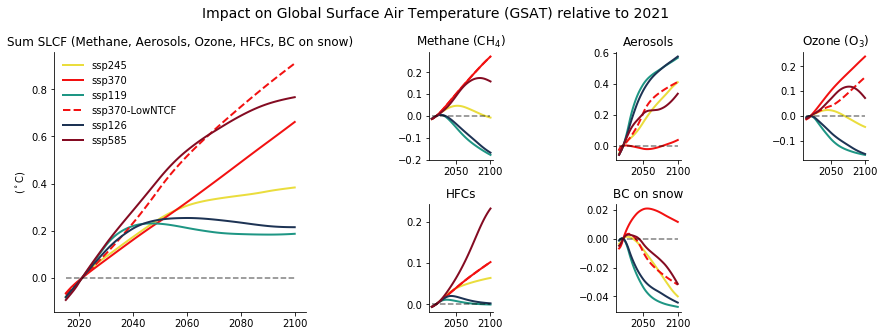

In [59]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel

# get_fig_ax_tot

import matplotlib.pyplot as plt

figsize = [20, 10]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

linewidth = 2


fig2, axs, ax_tot = get_fig_ax_tot(fgsize=[13, 4.4])  # fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
for var, ax in zip(variables_erf_comp, axs):

    print(var)

    # fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2))
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        # Choose median: 
        _pl_da = _da.sel(percentile='median')
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=linewidth)

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))

    ax.set_ylabel('')
    ax.set_xlabel('')
    fix_ax(ax)
    # Plot zero line:
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')

if len(axs)>len(variables_erf_comp):
    l = len(variables_erf_comp)
    for i in range(l,len(axs)):
        axs[l].axis('off')

# total:
ax = ax_tot

cdic = get_scenario_c_dic()
# for var in variables_erf_tot:  # , f_totn]:
for scn in list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                     year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile='median')
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), linestyle=lsdic[scn], linewidth=linewidth)

_ds = ds_DT.sel(year=slice(s_y2, e_y2))
ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
plt.suptitle('Impact on Global Surface Air Temperature (GSAT) relative to 2021', fontsize=14, y=1.05)
# adjust plot visuals:
_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl: 
    _str += f'{var}, '

# ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])
ax.set_title('Sum SLCF (%s)' % _str[:-2])
# ax.set_ylabel('$\Delta$ T ($^\circ$C)')
ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc='upper left')
fix_ax(ax)
plt.subplots_adjust(top=0.94, left=0.125, wspace=9.1, hspace=.5)
plt.tight_layout()
plt.savefig(FIGURE_DIR / 'total_ref2021_from2015_all_v1.png', dpi=300)
plt.savefig(FIGURE_DIR / 'total_ref2021_from2015_all_v1.pdf')  # , dpi=300)
plt.show()

ch4
aerosol-total
o3
HFCs
bc_on_snow


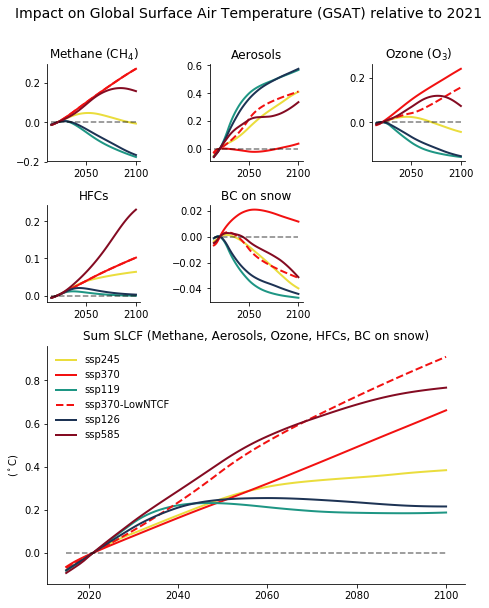

In [49]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel

# get_fig_ax_tot

import matplotlib.pyplot as plt

figsize = [6, 4]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

linewidth = 2

fig2, axs, ax_tot = get_fig_ax_tot(fgsize=[7, 8], rows_tot=2, cols_tot=0,
                                   orientation='vertical',
                                   tot_first=False)

# fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
for var, ax in zip(variables_erf_comp, axs):

    print(var)

    # fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2))
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        # Choose median: 
        _pl_da = _da.sel(percentile='median')
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=linewidth)

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))

    ax.set_ylabel('')
    ax.set_xlabel('')
    fix_ax(ax)
    # Plot zero line:
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')

if len(axs)>len(variables_erf_comp):
    l = len(variables_erf_comp)
    for i in range(l,len(axs)):
        axs[l].axis('off')
# Total:

ax = ax_tot

cdic = get_scenario_c_dic()
# for var in variables_erf_tot:  # , f_totn]:
for scn in list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                     year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile='median')
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), linestyle=lsdic[scn], linewidth=linewidth)

_ds = ds_DT.sel(year=slice(s_y2, e_y2))
ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
plt.suptitle('Impact on Global Surface Air Temperature (GSAT) relative to 2021', fontsize=14, y=1.05)
# adjust plot visuals:
_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl: _str += f'{var}, '
# ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])
ax.set_title('Sum SLCF (%s)' % _str[:-2])
# ax.set_ylabel('$\Delta$ T ($^\circ$C)')
ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc='upper left')
fix_ax(ax)
plt.subplots_adjust(top=0.94, left=0.125, wspace=9.1, hspace=.5)
plt.tight_layout()
plt.savefig(FIGURE_DIR / 'total_ref2021_from2015_all_2.png', dpi=300)
plt.savefig(FIGURE_DIR / 'total_ref2021_from2015_all_2.pdf')  # , dpi=300)
plt.show()

ch4


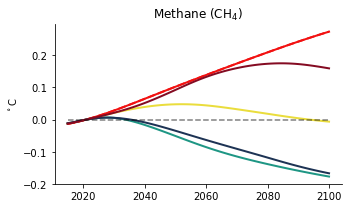

aerosol-total


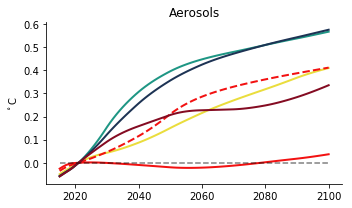

o3


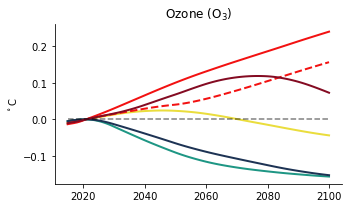

HFCs


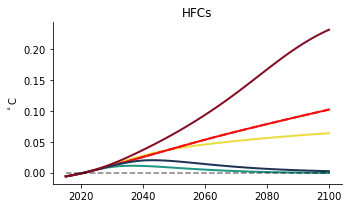

bc_on_snow


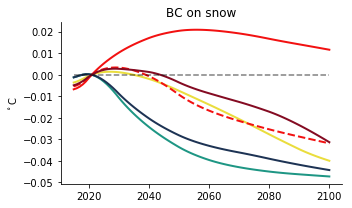

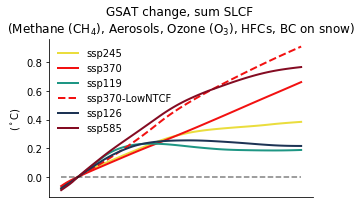

In [44]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel


# get_fig_ax_tot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders

figsize = [5, 3]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

linewidth = 2

# fig2, axs, ax_tot = get_fig_ax_tot()#fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
for var in variables_erf_comp:  # , axs):

    print(var)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2))
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        # Choose median: 
        _pl_da = _da.sel(percentile='median')
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=linewidth)

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))
    ax.set_ylabel('$^\circ$C')
    ax.set_xlabel('')
    fix_ax(ax)
    # Plot zero line:
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    # figname
    fign = FIGURE_DIR / fign_dt(var, s_y, s_y2)
    make_folders(str(fign))

    plt.tight_layout()
    plt.savefig(fign, dpi=300)
    plt.savefig(fign.with_suffix('.pdf'))  
    plt.show()

axs[0].set_ylabel('($^\circ$C)')
for ax in axs:
    # ax.set_ylabel('Change in temperature (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')

fig, ax = plt.subplots(1, 1, figsize=figsize)  # [9,5])

cdic = get_scenario_c_dic()
# for var in variables_erf_tot:  # , f_totn]:
for scn in list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                     year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile='median')
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), xticks=[], linestyle=lsdic[scn],
                linewidth=linewidth)

# adjust plot visuals:
_str = ''
for var in ds_DT.sel(variable=variables_erf_comp)[variable].values: _str += f'{get_var_nicename(var)}, '
ax.set_title('GSAT change, sum SLCF \n(%s)' % _str[:-2])

ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc=2)
fix_ax(ax)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')

plt.tight_layout()
fn = FIGURE_DIR / fign_dt('total', s_y, s_y2)
plt.savefig(fn, dpi=200)
plt.savefig(fn.with_suffix('.pdf'))  # , dpi=200)
plt.show()

# Supplementary plots:

## Plot $\Delta$ T and ERF with reference year +/- 1 standard deviation of the models

ch4


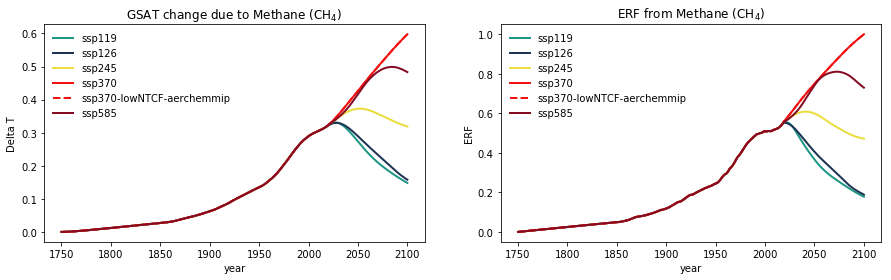

aerosol-total


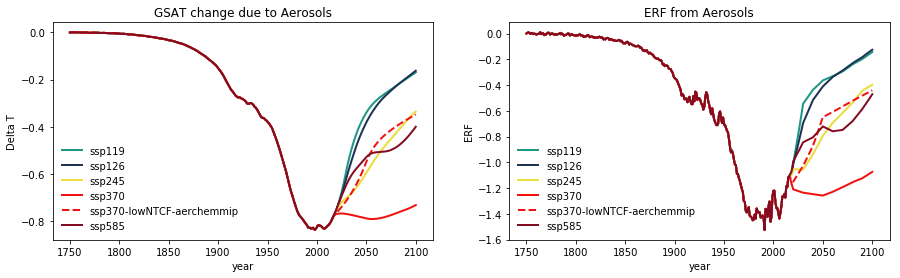

o3


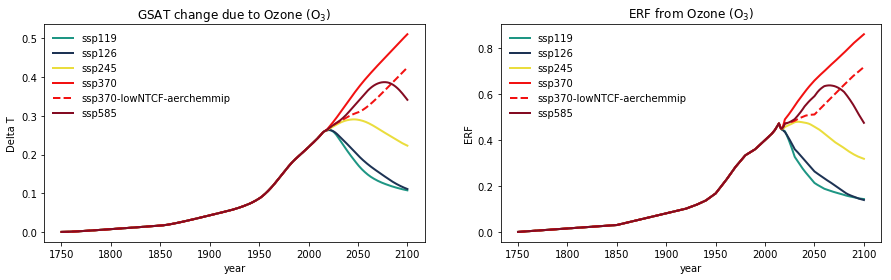

HFCs


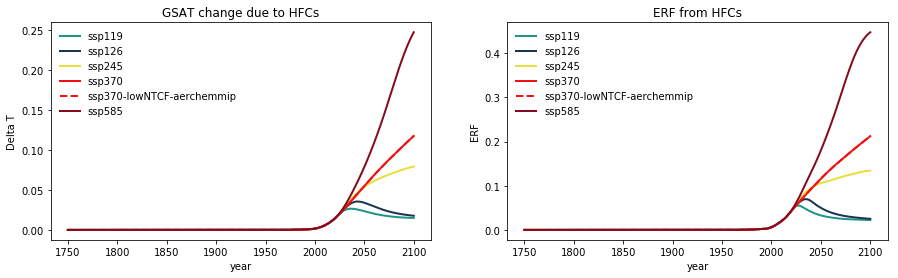

bc_on_snow


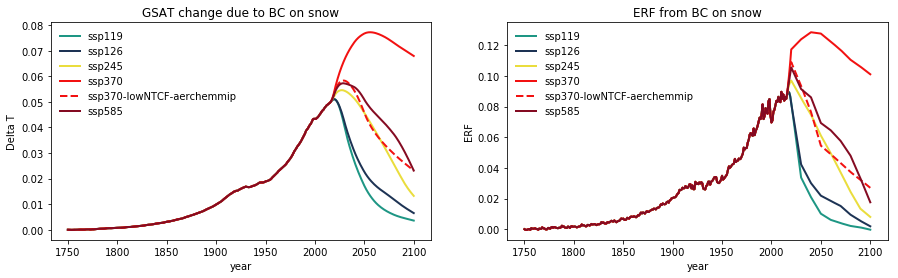

In [19]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:  # ) - {'historical'}):
        first = True

        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn).sel(percentile='median')
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn)
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da  # .sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=2)
    print(var)

    axs[0].set_title('GSAT change due to %s' % get_var_nicename(var))
    axs[1].set_title('ERF from %s' % get_var_nicename(var))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()

Subtracting year 2021, while still plotting from 2015. Thus the results represent the cooling/warming with respect to year 2021

ch4


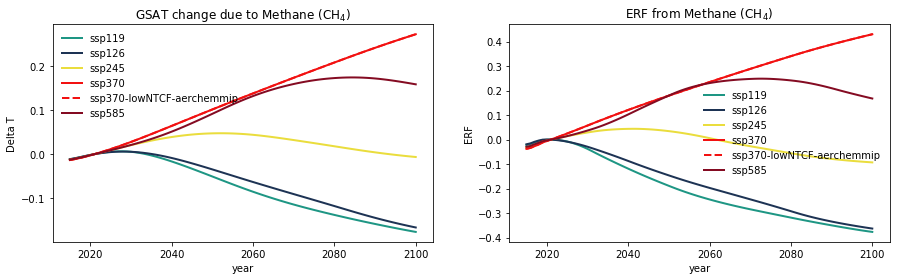

aerosol-total


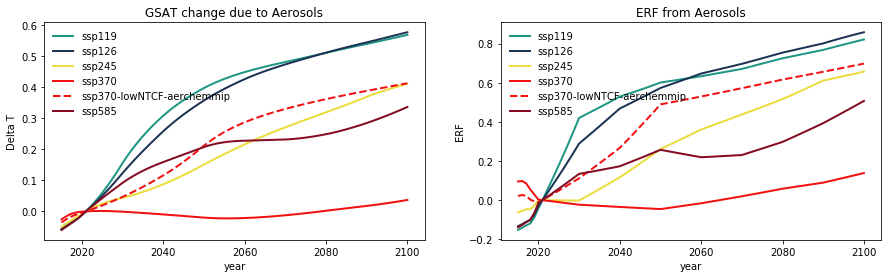

o3


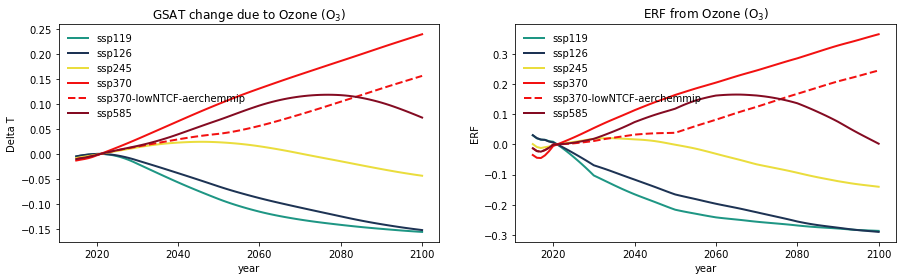

HFCs


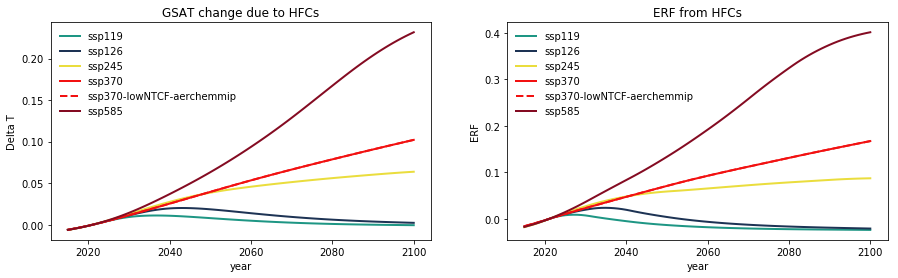

bc_on_snow


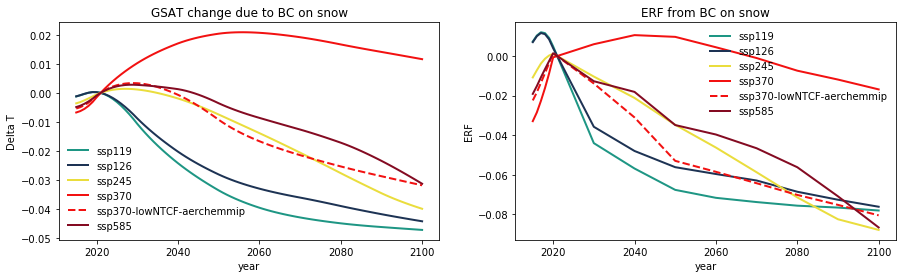

In [20]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:  # ) - {'historical'}):
        first = True
        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - ds_DT[name_deltaT].sel(
            variable=var, scenario=scn,
            year=slice(s_y, s_y)).squeeze()
        _da1 = _da1.sel(percentile='median')
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - ds_DT['ERF'].sel(variable=var,
                                                                                                       scenario=scn,
                                                                                                       year=slice(s_y,
                                                                                                                  s_y)).squeeze()
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da  # .sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=2)
    print(var)

    axs[0].set_title('GSAT change due to %s' % get_var_nicename(var))
    axs[1].set_title('ERF from %s' % get_var_nicename(var))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()